# Spleen 3D segmentation with MONAI

This tutorial shows how to run SageMaker managed training using MONAI for 3D Segmentation.
This tutorial shows how to run SageMaker managed inference after model training. 



This notebook and train.py script in source folder were derived from [spleen_segmentation_3d notebook](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

Key features demonstrated here:
1. SageMaker managed training with S3 integration
2. SageMaker hosted inference 

The Spleen dataset can be downloaded from https://registry.opendata.aws/msd/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size
    

### Install and import monai libraries 

In [1]:
!pip install  "monai[all]==0.8.0"
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     |████████████████████████████████| 709 kB 22.8 MB/s            
     |████████████████████████████████| 316 kB 57.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 148 kB 72.9 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 17.9 MB 71.3 MB/s            
     |████████████████████████████████| 232 kB 75.9 MB/s            
     |████████████████████████████████| 15.6 MB 49.8 MB/s            
     |████████████████████████████████| 8.5 MB 47.3 MB/s            
     |████████████████████████████████| 4.0 MB 51.6 MB/s            
     |████████████████████████████████| 297 kB 70.4 MB/s            
     |████████████████████████████████| 125 kB 76.7 MB/s            
     |████████████████████████████████| 3.3 MB 50.0 MB/s            
     |████████████████████████████████| 5.8 MB 56.9 MB/s       

     |████████████████████████████████| 42 kB 1.5 MB/s             
     |████████████████████████████████| 79 kB 11.2 MB/s            
     |████████████████████████████████| 210 kB 78.4 MB/s            
     |████████████████████████████████| 62 kB 156 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 170 kB 72.4 MB/s            
     |████████████████████████████████| 4.9 MB 43.8 MB/s            
     |████████████████████████████████| 97 kB 10.8 MB/s            
     |████████████████████████████████| 126 kB 80.1 MB/s            
     |████████████████████████████████| 156 kB 80.9 MB/s            
     |████████████████████████████████| 4.3 MB 37.9 MB/s            
     |████████████████████████████████| 781 kB 40.8 MB/s            
     |████████████████████████████████| 67 kB 7.7 MB/s             
     |████████████████████████████████| 895 kB 41.8 MB/s            
     |████████████████████████████████| 6.6 MB 39.3 MB/s           

  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp36-cp36m-linux_x86_64.whl size=16781 sha256=39d443ba5810ac897f4c4c538eb6fb4a1913ea92b7f9b495e6a6cd3a4a370577
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ac/d1/f8/f226d1f46dfe6c8fc332167949f318bd2fcb4e228aa4731259
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=71f53d1af87a4c40792b2a9016c679dc3cd26a746db883a715906d34a1bc8641
  Stored in directory: /home/ec2-user/.cache/pip/wheels/96/f9/d3/4594b3b2fe2ee239d0c9eb861f468204652e0a1c6d03755d75
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112628 sha256=ef104de9c2f422870d0026f5fed0a336f59cb7008a09a85bb5ec7060642c3003
  Stored in directory: /home/ec2-user/.cache/pip/wheels/68/76/52/8642fd2d5677e988a77b543279f7732ec5d1549bf4ee05c3c6
Successfully built openslide-python gdown databricks-cli
  Attempting uninstall: importlib-metadata
   

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob




MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [3]:
#import sagemaker libraries and get environment variables
import sagemaker 
from sagemaker import get_execution_role
role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()

## Prepare the dataset: Spleen dataset
+ Download the Spleen dataset if it is not available locally
+ Transform the images using Compose from MONAI
+ Visualize the image 

In [4]:
# Download the images
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
compressed_file = "./Task09_Spleen.tar"

MONAILabelServerIP = "../Spleen3D" ## you can change it to IP address of the MONAI Label Server if deployed
data_dir = MONAILabelServerIP 

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, data_dir+'/datasets', md5)

In [5]:
## transform the images through Compose
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  ## keys include image and label with image first
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [6]:
## divide the images into training and testing dataset

from monai.apps import download_and_extract
import os
import glob

train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-1], data_dicts[-1:]

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


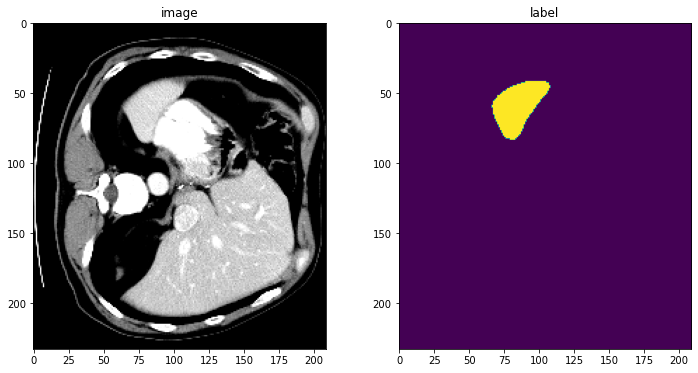

In [7]:
# Visualization

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot only the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Model training 

+ Divide the dataset into training and testing
+ Upload the dataset into S3 
+ SageMaker training job

In [8]:
## copy dataset for training 
!mkdir -p ../Spleen3D/train/imagesTr
!mkdir -p ../Spleen3D/train/labelsTr

## folder for testing dataset
!mkdir -p ../Spleen3D/test/imagesTr
!mkdir -p ../Spleen3D/test/labelsTr

In [9]:
## copy dataset for training 
for file in train_files:
    image = file['image']
    image_dest = "../Spleen3D/train/imagesTr"
    label = file['label']
    label_dest = "../Spleen3D/train/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [10]:
## copy dataset for testing  
for file in val_files:
    image = file['image']
    image_dest = "../Spleen3D/test/imagesTr"
    label = file['label']
    label_dest = "../Spleen3D/test/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [11]:
## upload the dataset to S3
prefix="MONAI-Segmentation"
bucket = sess.default_bucket()
## upload training dataset
S3_inputs = sess.upload_data(
    path="../Spleen3D/train",
    key_prefix=prefix+"/train",
    bucket=bucket 
)

## upload testing dataset
S3_test = sess.upload_data(
    path="../Spleen3D/test",
    key_prefix=prefix+"/test",
    bucket=bucket 
)


### SageMaker training job

In [ ]:
%%time 
import sagemaker
from sagemaker.inputs import FileSystemInput
from sagemaker.pytorch import PyTorch

metrics=[
   {'Name': 'train:average epoch loss', 'Regex': 'average loss: ([0-9\\.]*)'},
   {'Name': 'train:current mean dice', 'Regex': 'current mean dice: ([0-9\\.]*)'},
   {'Name': 'train:best mean dice', 'Regex': 'best mean dice: ([0-9\\.]*)'}
]

estimator = PyTorch(source_dir='code',
                    entry_point='train.py',
                    role=role,
                    framework_version='1.6.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.p2.xlarge',
                    hyperparameters={
                       "seed": 123,
                       "lr": 0.001,
                       "epochs": 10
                    },
                    metric_definitions=metrics,
#                     ### spot instance training ###
#                    use_spot_instances=True,
#                     max_run=2400,
#                     max_wait=2400
                )


estimator.fit(S3_inputs)

2022-04-29 10:19:58 Starting - Starting the training job...ProfilerReport-1651227598: InProgress
......
2022-04-29 10:21:26 Starting - Preparing the instances for training.........
2022-04-29 10:22:46 Downloading - Downloading input data......
2022-04-29 10:23:56 Training - Downloading the training image.................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-29 10:26:37,043 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-29 10:26:37,070 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-29 10:26:37,082 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-29 10:26:37,645 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt
  Installing build dependencies: started
  Installing build dependenci

  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp36-cp36m-linux_x86_64.whl size=22912 sha256=164968b8de988640e3d7963d75518e4f1e761643d9acc7e704226beae7ab1ac1
  Stored in directory: /root/.cache/pip/wheels/ac/d1/f8/f226d1f46dfe6c8fc332167949f318bd2fcb4e228aa4731259
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=51a2cb46ec475ce8704e886a6979830b5cf56f48667db3a03a2c44f7478534e0
  Stored in directory: /root/.cache/pip/wheels/96/f9/d3/4594b3b2fe2ee239d0c9eb861f468204652e0a1c6d03755d75
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112628 sha256=be83a03e714b32330eb84d399554d13fa6a289a8f04d32a74fc6944c7895de2c
  Stored in directory: /root/.cache/pip/wheels/68/76/52/8642fd2d5677e988a77b543279f7732ec5d1549bf4ee05c3c6
Successfully built openslide-python gdown databricks-cli
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
     

Distributed training - False
Number of gpus available - 1
[2022-04-29 10:28:09.593 algo-1:66 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-29 10:28:09.822 algo-1:66 INFO profiler_config_parser.py:102] User has disabled profiler.
[2022-04-29 10:28:09.824 algo-1:66 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2022-04-29 10:28:09.825 algo-1:66 INFO hook.py:199] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2022-04-29 10:28:09.826 algo-1:66 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2022-04-29 10:28:09.827 algo-1:66 INFO hook.py:199] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2022-04-29 10:28:09.828 algo-1:66 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2022-04-29 10:28:09.828 algo-1:66 INFO 

In [ ]:
## you can get the model artifact here
model_data=estimator.__dict__['output_path']+estimator.__dict__['_current_job_name']+'/output/model.tar.gz'

## a neater version to fetch model artifact
model_data=estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]

In [175]:
model_data

's3://sagemaker-us-east-1-741261399688/pytorch-training-2022-04-29-06-55-43-804/output/model.tar.gz'

In [ ]:
#model_data='s3://sagemaker-us-east-1-741261399688/model_artifact/model.tar.gz'

In [ ]:
from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(
    entry_point="inference.py", ## inference code with customization
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)

predictor = model.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m5.2xlarge',
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

In [19]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":80}


response=predictor.predict(payload)

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 9.17 s


In [20]:
response

{'s3_path': 'S3://sagemaker-us-east-1-741261399688/inference_output/results_slides1651228919.0706944.json',
 'pred': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [21]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":100}


response=predictor.predict(payload)

CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 9.44 s


In [22]:
response

{'s3': 'S3://sagemaker-us-east-1-741261399688/inference_output/results_slides1651229045.6711493.json'}

In [24]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":200}


response=predictor.predict(payload)

CPU times: user 4.32 ms, sys: 0 ns, total: 4.32 ms
Wall time: 9.93 s


In [25]:
response

{'s3': 'S3://sagemaker-us-east-1-741261399688/inference_output/results_slides1651229087.6610005.json'}

In [146]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":80}


response=predictor_async.predict_async(payload)

CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 110 ms


In [147]:
response

In [148]:
response.get_result()

ObjectNotExistedError: Object not exist at s3://sagemaker-us-east-1-741261399688/Inference_output/segmentation/output/5236acc9-b410-4e2e-abec-0c7597a359af.out. Inference could still be running

In [141]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":100}


response2=predictor_async.predict_async(payload)

CPU times: user 26.2 ms, sys: 0 ns, total: 26.2 ms
Wall time: 160 ms


In [142]:
response2.get_result()

ObjectNotExistedError: Object not exist at s3://sagemaker-us-east-1-741261399688/Inference_output/segmentation/output/e192123e-7b64-49c0-861f-fe7e53dd053a.out. Inference could still be running

In [127]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":200}


response3=predictor_async.predict_async(payload)

CPU times: user 6.97 ms, sys: 0 ns, total: 6.97 ms
Wall time: 57.9 ms


In [128]:
response2 = response.get_result()

ObjectNotExistedError: Object not exist at s3://sagemaker-us-east-1-741261399688/Inference_output/segmentation/output/611878c1-43a5-49a5-a838-e359d1fa26a6.out. Inference could still be running

## Inference 

+ deploy the model with customized inference script
+ inference with testing image in S3
+ visualization the results
+ deployment with trained estimator or the model artifact in S3.


### Type of inference
SageMaker provides the flexibility of deploying endpoints with the following 3 options: 
+ realtime inference
+ asychronous inference
+ batch transform

Customers can select the corresponding option based on the budget and requirements. 

I am going to demonstrate the realtime and asynchronous deployment options in the following scripts 

In [92]:
## realtime endpoint

predictor = estimator.deploy(initial_instance_count=1,entry_point='inference.py', instance_type='ml.m5.2xlarge',serializer=sagemaker.serializers.JSONSerializer(),deserializer=sagemaker.deserializers.JSONDeserializer())

-------!

In [93]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":80}
response=predictor.predict(payload)

CPU times: user 17.9 ms, sys: 3.16 ms, total: 21 ms
Wall time: 9.95 s


### Asynchronous inference endpoint



In [65]:
from sagemaker.async_inference import AsyncInferenceConfig

s3_bucket=bucket

bucket_prefix = 'Inference_output' ## output for the inference
output_path=f"s3://{s3_bucket}/{bucket_prefix}/segmentation/output"

async_config = AsyncInferenceConfig(
    output_path=output_path,
    max_concurrent_invocations_per_instance=5
)

In [68]:
predictor_async = estimator.deploy(initial_instance_count=1,
                             entry_point='inference_async.py', 
                             instance_type='ml.m5.2xlarge',
                             serializer=sagemaker.serializers.JSONSerializer(),
                             deserializer=sagemaker.deserializers.JSONDeserializer(),
                             async_inference_config=async_config)


-------!

In [88]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":200}


response=predictor_async.predict(payload)

PollingTimeoutError: No result at s3://sagemaker-us-east-1-741261399688/Inference_output/segmentation/output/c6dccd43-d2dc-456f-b233-4c22f67374fb.out after polling for 900 seconds. Inference could still be running

In [89]:
%%time
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test/imagesTr",
    "file":'spleen_9.nii.gz',
    "nslice":70}


response=predictor_async.predict(payload)

KeyboardInterrupt: 

In [51]:
import json
with open('input.json', 'w') as f:
    json.dump(payload, f)
    
## upload testing dataset
input_payload = sess.upload_data(
    path="input.json",
    key_prefix=prefix+"/test_json",
    bucket=bucket 
)

In [56]:
input_payload

's3://sagemaker-us-east-1-741261399688/MONAI-Segmentation/test_json/input.json'

In [52]:
%%time
response=predictor_async.predict(input_path=input_payload)

PollingTimeoutError: No result at s3://sagemaker-us-east-1-741261399688/Inference_output/segmentation/output/13bf059a-83d0-48a8-b079-c14988e210eb.out after polling for 900 seconds. Inference could still be running

In [ ]:
# Tears down the SageMaker endpoint and endpoint configuration if no longer needed
predictor_async.delete_endpoint()

## Visulaize the result

In [ ]:
torch.Tensor(response["pred"])

In [ ]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1,3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.Tensor(response["pred"]))

        plt.show()

## Clean up the resources

+ delete all the endpoints to save cost

In [163]:
import boto3
client = boto3.client('sagemaker')
endpoints=client.list_endpoints()['Endpoints']
endpoints

[{'EndpointName': 'pytorch-inference-2022-04-28-11-57-42-082',
  'EndpointArn': 'arn:aws:sagemaker:us-east-1:741261399688:endpoint/pytorch-inference-2022-04-28-11-57-42-082',
  'CreationTime': datetime.datetime(2022, 4, 28, 11, 57, 42, 305000, tzinfo=tzlocal()),
  'LastModifiedTime': datetime.datetime(2022, 4, 28, 12, 13, 45, 138000, tzinfo=tzlocal()),
  'EndpointStatus': 'InService'},
 {'EndpointName': 'pytorch-inference-2022-04-28-09-33-15-460',
  'EndpointArn': 'arn:aws:sagemaker:us-east-1:741261399688:endpoint/pytorch-inference-2022-04-28-09-33-15-460',
  'CreationTime': datetime.datetime(2022, 4, 28, 9, 33, 15, 709000, tzinfo=tzlocal()),
  'LastModifiedTime': datetime.datetime(2022, 4, 28, 9, 37, 5, 711000, tzinfo=tzlocal()),
  'EndpointStatus': 'InService'},
 {'EndpointName': 'pytorch-inference-2022-04-28-09-03-05-798',
  'EndpointArn': 'arn:aws:sagemaker:us-east-1:741261399688:endpoint/pytorch-inference-2022-04-28-09-03-05-798',
  'CreationTime': datetime.datetime(2022, 4, 28, 9

In [164]:
for endpoint in endpoints:
    response = client.delete_endpoint(
        EndpointName=endpoint['EndpointName']
    )